In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from kneed import KneeLocator
from sklearn.metrics import silhouette_score


<br></br>
***
***
<br></br>

# Read CSV

In [2]:
penguins = pd.read_csv("2021-11-ml-09-k-means-animals-dataset.csv")
penguins.head()

,Region,Stage,Individual ID,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,Anvers,"Adult, 1 Egg Stage",N1A1,39.1,18.7,181.0,3750.0,NaN,NaN,Not enough blood for isotopes.
1,Anvers,"Adult, 1 Egg Stage",N1A2,39.5,17.4,186.0,3800.0,8.94956,-24.69454,NaN
2,Anvers,"Adult, 1 Egg Stage",N2A1,40.3,18.0,195.0,3250.0,8.36821,-25.33302,NaN
3,Anvers,"Adult, 1 Egg Stage",N2A2,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,Anvers,"Adult, 1 Egg Stage",N3A1,36.7,19.3,193.0,3450.0,8.76651,-25.32426,NaN


<br></br>
***
***
<br></br>

# DEA (Data Exploritory Analysis)

### Check for NaN values in each column.

In [3]:
penguins.isnull().sum()

Region                   0
Stage                    0
Individual ID            0
Culmen Length (mm)       2
Culmen Depth (mm)        2
Flipper Length (mm)      2
Body Mass (g)            2
Delta 15 N (o/oo)       14
Delta 13 C (o/oo)       13
Comments               318
dtype: int64

### Seaborn pairplot to understand general overview of dataset with relational scatter plots of all numerical columns and histographs going over counts of values in each colum.

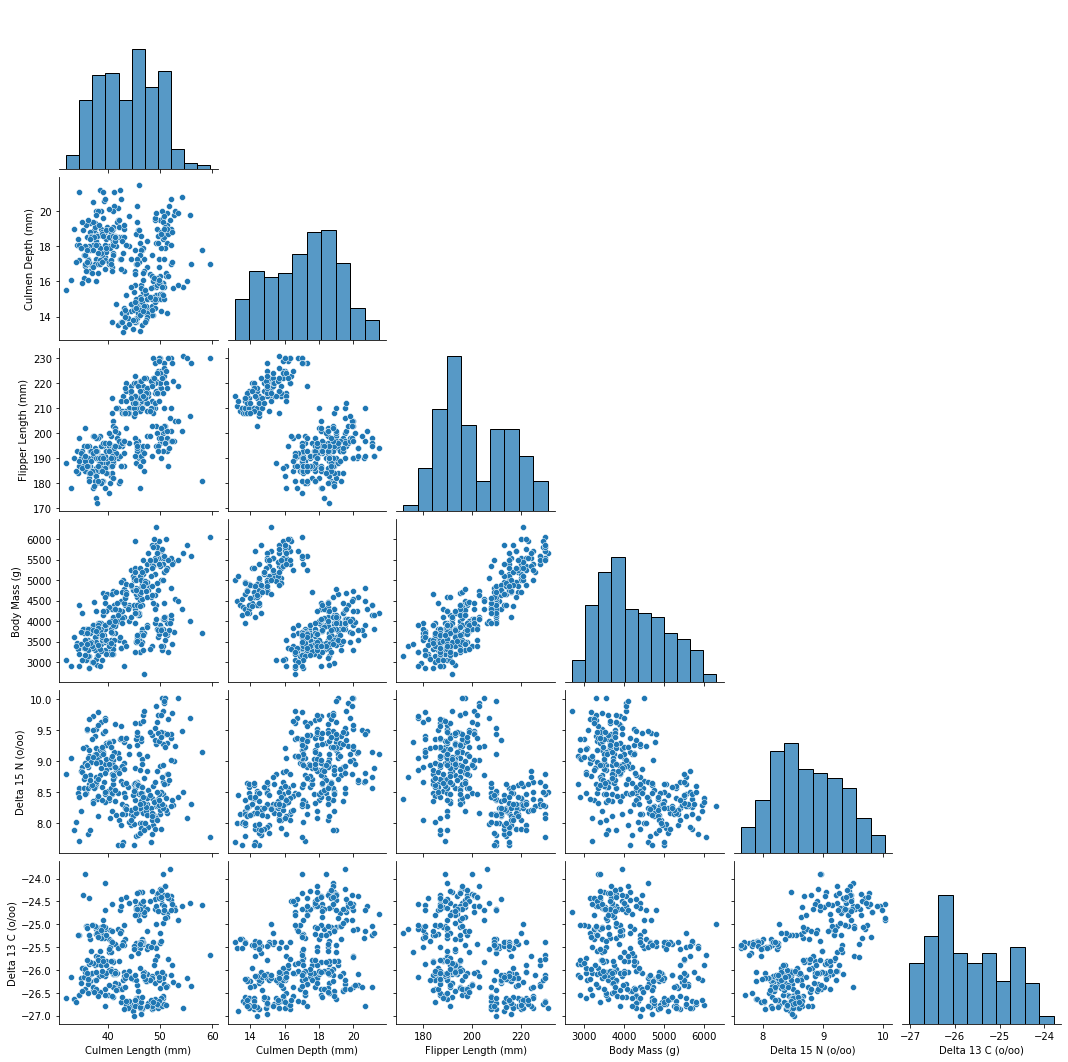

In [4]:
sns.pairplot(penguins, corner=True)

### Outlier detection of all numeric columns in dataset.

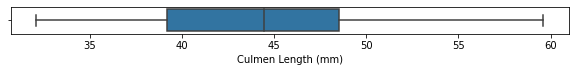

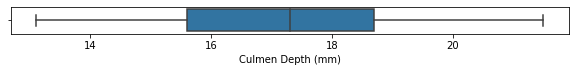

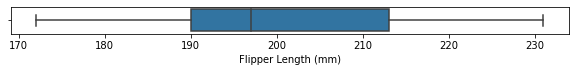

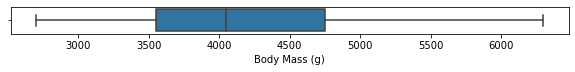

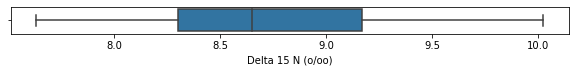

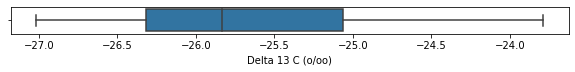

In [5]:
# outlier detection
penguins_numerical =penguins.select_dtypes(exclude=['object'])
for column in penguins_numerical:
    plt.figure(figsize=(10,0.5))
    sns.boxplot(data=penguins_numerical, x=column)

<br></br>
***
***
<br></br>

# Data Cleaning

### Remove 'Comments' column as it is nearly all NaNs.

In [6]:
penguins = penguins.drop("Comments", axis=1)

### Remove any rows in the dataset that have more the 50% NaNs in the row.

In [7]:
print("Before:", penguins.shape[0])
min_count = 0.5* penguins.shape[1]
penguins = penguins.dropna(axis=0, thresh = min_count)
print("After:", penguins.shape[0])
penguins.info()


Before: 344
After: 342
<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 0 to 343
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Region               342 non-null    object 
 1   Stage                342 non-null    object 
 2   Individual ID        342 non-null    object 
 3   Culmen Length (mm)   342 non-null    float64
 4   Culmen Depth (mm)    342 non-null    float64
 5   Flipper Length (mm)  342 non-null    float64
 6   Body Mass (g)        342 non-null    float64
 7   Delta 15 N (o/oo)    330 non-null    float64
 8   Delta 13 C (o/oo)    331 non-null    float64
dtypes: float64(6), object(3)
memory usage: 26.7+ KB


### Impute on columns 'Delta 15 N (o/oo)' and 'Delta 13 C (o/oo)' for NaN values using the median

In [8]:
imputer_continuos = SimpleImputer(missing_values=np.nan, strategy="median")

penguins["Delta 15 N (o/oo)"] = imputer_continuos.fit_transform(penguins["Delta 15 N (o/oo)"].values.reshape(-1,1))[:,0]
penguins["Delta 13 C (o/oo)"] = imputer_continuos.fit_transform(penguins["Delta 13 C (o/oo)"].values.reshape(-1,1))[:,0]
penguins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 0 to 343
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Region               342 non-null    object 
 1   Stage                342 non-null    object 
 2   Individual ID        342 non-null    object 
 3   Culmen Length (mm)   342 non-null    float64
 4   Culmen Depth (mm)    342 non-null    float64
 5   Flipper Length (mm)  342 non-null    float64
 6   Body Mass (g)        342 non-null    float64
 7   Delta 15 N (o/oo)    342 non-null    float64
 8   Delta 13 C (o/oo)    342 non-null    float64
dtypes: float64(6), object(3)
memory usage: 26.7+ KB


### Look into both 'Region' and 'Stage' column values to see if this categorical data would be worth turning into dummy columns to better improve the algorithm used later on.

In [9]:
print(penguins["Region"].unique())
print(penguins["Stage"].unique())

['Anvers']
['Adult, 1 Egg Stage']


### All values in 'Region' and 'Stage' only show one label making them identifiers for what is likly a larger database encompassing animals, so let's remove them for the dataset as they won't impove our algorithm's learning ability later on.

In [10]:
penguins = penguins.drop(["Region", "Stage", "Individual ID"] , axis=1)

### Check cleaned dataset to make sure there are no NaNs and only numerical data remaining.

In [11]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 0 to 343
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Culmen Length (mm)   342 non-null    float64
 1   Culmen Depth (mm)    342 non-null    float64
 2   Flipper Length (mm)  342 non-null    float64
 3   Body Mass (g)        342 non-null    float64
 4   Delta 15 N (o/oo)    342 non-null    float64
 5   Delta 13 C (o/oo)    342 non-null    float64
dtypes: float64(6)
memory usage: 18.7 KB


<br></br>
***
***
<br></br>

# Take cleaned Data and standardize it using sklearn's StandardScaler() function

In [12]:
# Standardize data (0 mean, 1 stdev)
def StandardizeDataFrame(df):
    scaler = StandardScaler().fit(df)
    nested_list = scaler.transform(df)
    return nested_list

In [13]:
def CreateDataFrame(nested_list):
    columns = len(nested_list[0])
    headers = []
    for i in range(1, columns+1):
        headers.append(f'Column {i}')
    df = pd.DataFrame(nested_list, columns=headers)
    return df

In [14]:
penguins = CreateDataFrame(StandardizeDataFrame(penguins))

### Look over general statistics of new standarized data

In [15]:
penguins.describe()

,Column 1,Column 2,Column 3,Column 4,Column 5,Column 6
count,3.420000e+02,3.420000e+02,3.420000e+02,3.420000e+02,3.420000e+02,3.420000e+02
mean,-9.024620e-17,-1.884782e-15,-4.875892e-16,9.414172e-17,-1.243969e-15,8.537680e-17
std,1.001465e+00,1.001465e+00,1.001465e+00,1.001465e+00,1.001465e+00,1.001465e+00
min,-2.168526e+00,-2.054446e+00,-2.059320e+00,-1.875362e+00,-2.028753e+00,-1.701198e+00
25%,-8.615697e-01,-7.866355e-01,-7.773731e-01,-8.138982e-01,-7.843473e-01,-7.743457e-01
50%,9.686524e-02,7.547549e-02,-2.788381e-01,-1.895079e-01,-1.443245e-01,-1.826038e-01
75%,8.397670e-01,7.854492e-01,8.606705e-01,6.846384e-01,7.586618e-01,7.816905e-01
max,2.875868e+00,2.205397e+00,2.142618e+00,2.620248e+00,2.391819e+00,2.439138e+00


<br></br>
***
***
<br></br>

# K-Means Exploritory Analysis

In [16]:
kmeans_list = []
for i in range(2,25):
    kmeans = KMeans(n_clusters=i, random_state=0)
    pca = PCA(2)
    penguins = pca.fit_transform(penguins)
    penguins = CreateDataFrame(penguins)
    label = kmeans.fit_predict(penguins)
    kmeans_list.append((i, kmeans, label))

Number of clusters: 2
Silhoutte Score = 0.5906054727735317


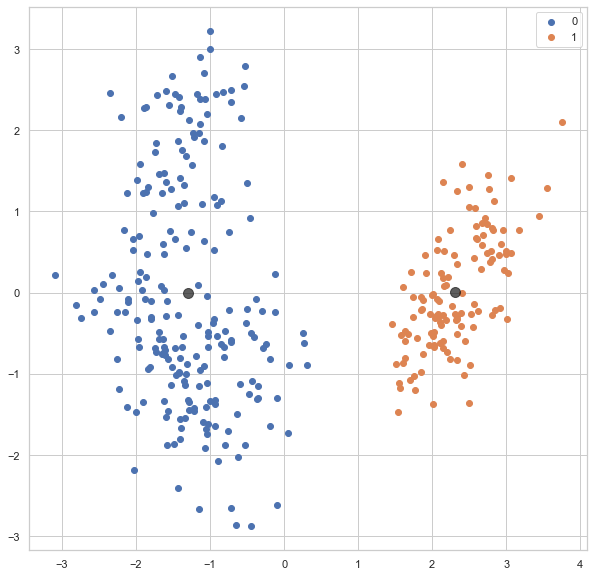

Number of clusters: 3
Silhoutte Score = 0.6024305833245073


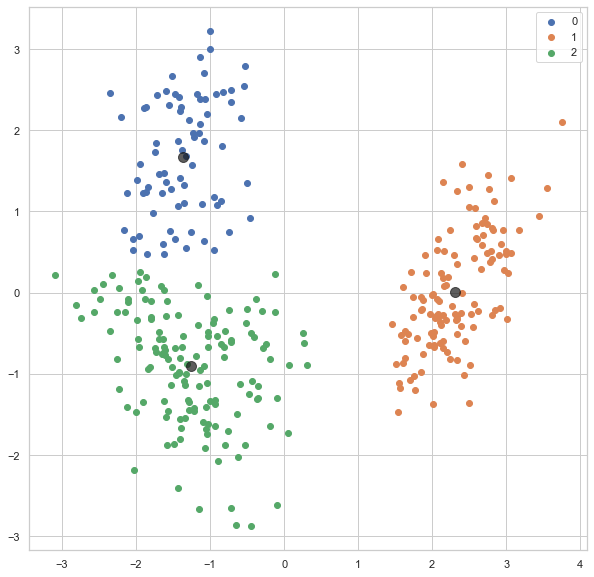

Number of clusters: 4
Silhoutte Score = 0.5167254926654827


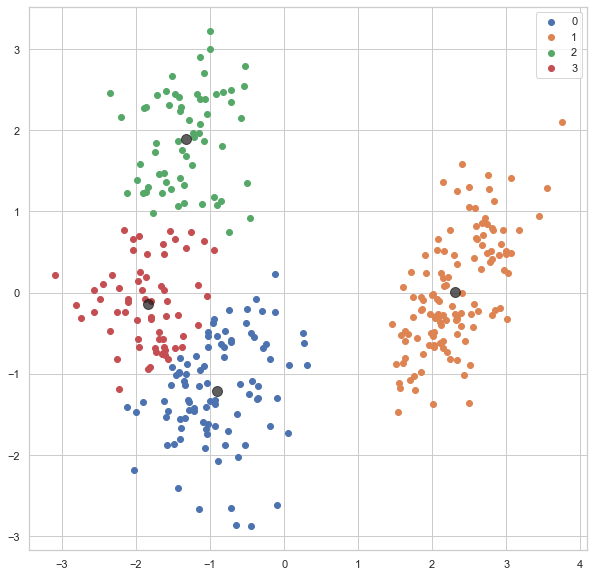

Number of clusters: 5
Silhoutte Score = 0.4547940036756907


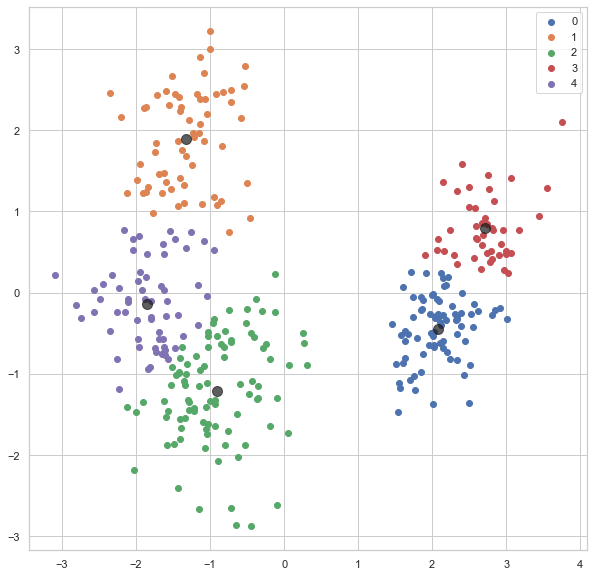

Number of clusters: 6
Silhoutte Score = 0.4619072511100099


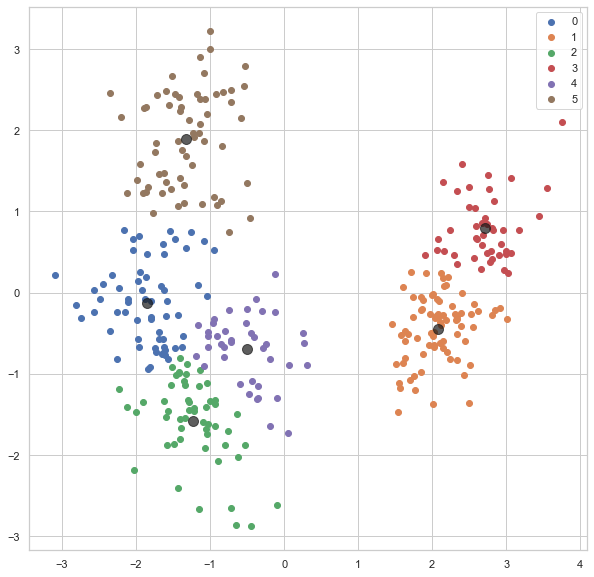

Number of clusters: 7
Silhoutte Score = 0.44895996484154754


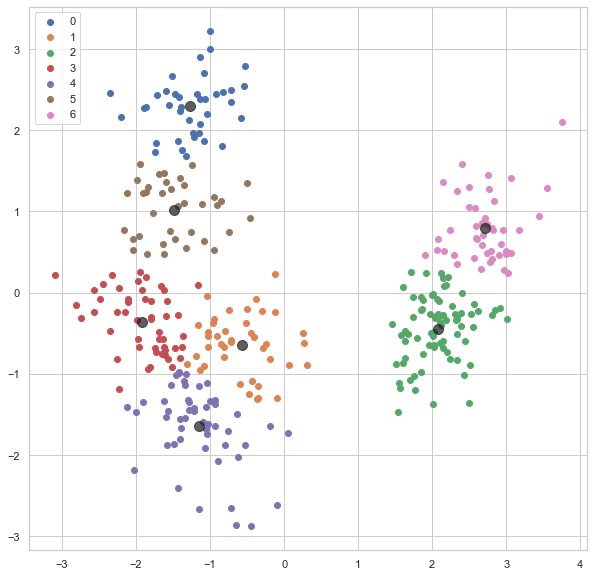

In [17]:
sns.set_theme(style="whitegrid")
for label_km in kmeans_list[:6]:
    cluster = label_km[0]
    kmeans = label_km[1]
    label = label_km[2]
    #Getting unique labels
    u_labels = np.unique(label)
    centroids = kmeans.cluster_centers_

    #plotting the results:
    print(f"Number of clusters: {cluster}")
    silhouette = silhouette_score(penguins, kmeans.labels_) 
    print(f"Silhoutte Score = {silhouette}")
    fig = plt.figure(figsize=(10, 10))
    for i in u_labels:
        plt.scatter(penguins.iloc[label == i , 0] , penguins.iloc[label == i , 1] , label = i)
    plt.scatter(centroids[:,0] , centroids[:,1] , s = 100, color = 'k', alpha=0.7)
    plt.legend()
    plt.show()

# Scree Plot

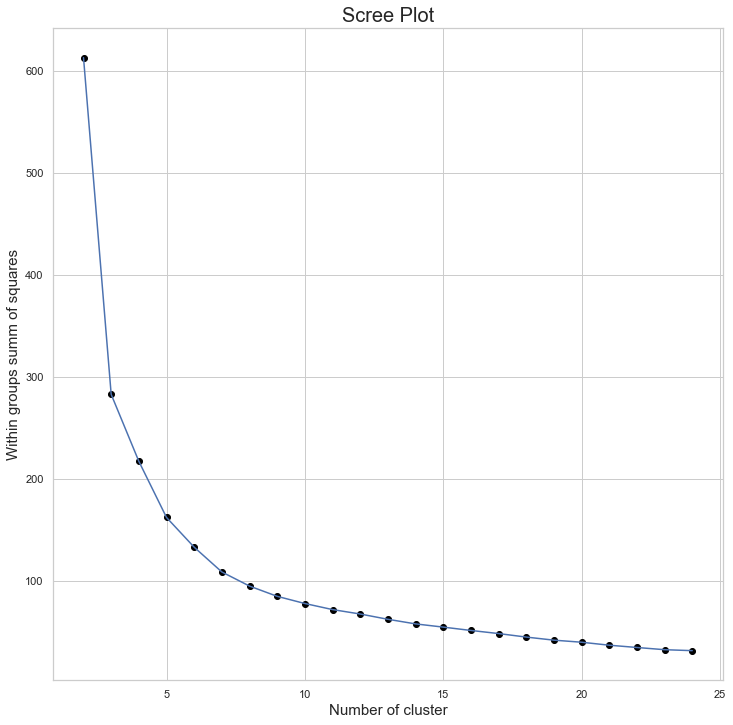

In [18]:
capture_accuracy = {}
for k in kmeans_list:
    cluster = k[0]
    kmeans = k[1]
    label = k[2]
    capture_accuracy[cluster] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure(figsize=(12,12))
plt.plot(list(capture_accuracy.keys()), list(capture_accuracy.values()))
plt.scatter(list(capture_accuracy.keys()), list(capture_accuracy.values()), color='black')
plt.xlabel("Number of cluster", fontsize = 15)
plt.ylabel("Within groups summ of squares", fontsize = 15)
plt.title("Scree Plot", fontsize = 20)
plt.show()

It seems that the elbow of the scree plot is around 5-7 clusters. For ease of implementation 5 clusters would likely be easiert to use, however for slightly better results 7 clusters can be used. After 7 clusters the Kmeans algorithm mostly levels out.

# Confirm elbow of K-means graph

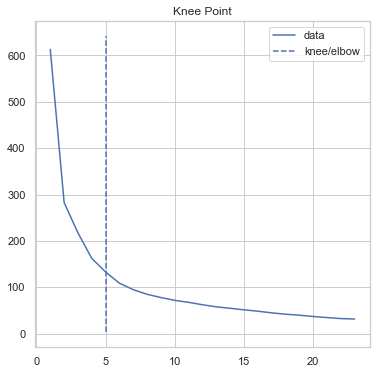

In [19]:
elbow = KneeLocator(range(1,len(list(capture_accuracy.keys()))+1),  #x values
                      list(capture_accuracy.values()), # y values
                      S=1.0, #parameter suggested from paper
                      curve="convex", #parameter from figure
                      direction="decreasing") #parameter from figure
                      
elbow.plot_knee()

In [20]:
print(elbow.knee)

5


<br></br>
***
***
<br></br>